##**Least Square classifier from scratch**


* Least square classification is used for estimating parameters of dicriminant function from the given training data.
* Least square classification adapts linear regression model for classification
    * it uses **least square error** as a loss function
    * it uses **normal equation** method and **gradident descent** for estimation model parameters or weight vector.
* Since it is a classification algorithim we would use classification related evaluation metrics such as precision,recall,F-1 score,AUC ROC/PR,and accuracy

Additianally note that:
* We make use of polynomial feature transformation.<br>
$\mathbf{y}=w_0+\mathbf{w}^T\phi(x)$

where $\phi(x)$ is a polynomial feature transformation.

* We can tackle issues of overfitting by using ridge or lasso just like linear regression model.

In [ ]:
from IPython.display import display,Math,Latex  #for proper rendering of latex in colab
import numpy as np

# for generating plots
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
#@title [Polynomial Transformation]
import numpy as np
import itertools
import functools
def get_combinations(x,degree):
  return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
  #reduce (lambda x,y:x*y, {1,2,3,4,5} calculates ((((1*2)*3)*4)*5)

  return functools.reduce(lambda x,y:x*y,items)
  
def polynomial_transform(x,degree,logging=False):

  #converts to feature matrix
  if x.ndim==1:
    x=x[:,None]  #creates [1,2,3] to [[1],[2],[3]]
  
  x_t=x.T
  features=[np.ones(len(x))]

  if logging:
    print("Input",x)
  for p in range(1,degree+1):
    for items in get_combinations(x_t,p): #generate combinations
      features.append(compute_new_feature(items)) #combine features into a feature
      if logging:
        print(items,":",compute_new_feature(items))

  if logging:
    print(np.asarray(features).T)
  return np.asarray(features).T     

##Lable Encoding

Since the output y is a descrete quantity we use one-hot-encoding to represent label.For a binary classification
* The label 0 is represented with [1,0], and
* The label 1 is represented with [0,1].
The same scheme is exteneded to the multi-class setting .In general for a  $k$ class set up we use one hot encoding in  $k$ component vector[$y_1,y_2,.....,y_k$].For label $1<=r<=k,y_r$ would be 1 and other components would be 0.

Let's see for three class classification set up:
* The label 0 is represented with [1,0,0]
* The label 1 is represented with [0,1,0]
* The label 2 is represented with [0,0,1]

In [ ]:
class LabelTransformer(object):
  '''
  Label encoder decoder
  Attributes
  ------------
  n_classes:int
    number of classes,K
  '''

  def __init__(self,n_classes:int=None):
    self.n_classes=n_classes
  
  @property
  def n_classes(self):
    return self.__n_classes

  @n_classes.setter
  def n_classes(self,K):
    self.__n_classes=self.__encoder=None if K is None else np.eye(K)

  @property
  def encoder(self):
    return self.__encoder

  def encode(self,class_indices:np.ndarray):
    '''
    encode class index into one-of-k code
    Parameters
    ----------
      class_indices:(N,) np.ndarray
      non-negative class index
      elements must be integer in [0,n_classes]
    Returns
    ----------
    (N,K) np.ndarray
      one-of-k encoding of input
    '''
    if self.n_classes is None:
      self.n_classes=np.max(class_indices)+1
    return self.encoder[class_indices]

  def decode(self,onehot:np.ndarray):
    '''
    decode one-of-k into class index
    Parameters
    ----------
    onehot:(N,K) np.ndarray
      one-of-k code
    Returns
    ----------
    (N) np.ndarray
      class index
    '''
    return np.argmax(onehot,axis=1)

In [ ]:
binary_labels=LabelTransformer(2).encode(np.array([1,0,1,0]))
binary_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [ ]:
multiclass_labels=LabelTransformer(3).encode(np.array([1,0,1,2]))
multiclass_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

##Least square classification implementation

###Training data
This representation of label has an impact on the learning set up.Now we have
* A feature matrix $X$ of shape $(n,m)$ where $n$ is the number of examples ,$m$ is the number of features
* A labels matrix $Y$ of shape $(n,k)$ where k is number of class labels.Note that this set up is similar to multiple regression

###Model

The label matrix is obtained by matrix multiplication of feature matrix and weight matrix.After adding a dummy feature to feature matrix ,its shape becomes $n$x$(m+1)$

$Y_{n.(m+1)}=X_{n.(m+1)}W_{(m+1).k}$

There is one weight vector per output

###Loss Function

  watch the vedio

In [ ]:
# @title [Least Square Classification class]
class LeastSquareClassification(object):
    '''            I
        Linear regression model
        y=xew
        X:Afeature matrix
        w:weight vector
        y:label vector
    '''
    def __init__(self):
      self.t0=20
      self.t1=1000
    def predict(self,X:np.ndarray)->np.ndarray:
      '''Prediction of output label foragiven input.
      Args:
        X:Feature matrix for given inputs.
      Returns:
        y:Output label vector as predicted by the given model.
      '''
      assert X.shape[-1]==self.w.shape[0],f"X shape {X.shape} and w shape {self.w.shape},are not compatible"
      return np.argmax(X@self.w,axis=-1)

    def predict_internal(self,X:np.ndarray)->np.ndarray:
      '''
        Prediction of output label for a given input.

        Args:
          X:Feature matrix for given inputs
        Returns:
          y:Output label vector encoded in label encoder format
      '''
      assert X.shape[-1]==self.w.shape[0],f"X shape {X.shape} and w shape {self.w.shape},are not compatible"
      return X@self.w
    def loss(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->float:
      ''' Calculates loss foramodel based on known labels.
          Args:
            X:Feature matrix for given inputs.
            y:Output label vector as predicted by the given model.
          Returns:
            Loss
      '''
      e=self.predict_internal(X)-y
      # return (1/2)*(np.transpose(e)@e)
      return (1/2)*(np.transpose(e)@e)+(reg_rate/2)*(np.transpose(self.w)@self.w)
    def rmse(self,X:np.ndarray,y:np.ndarray)->float:
      ''' Calculates root mean squared error of prediction w.r.t. actual label.
          Args:
          X:Feature matrix for given inputs.
          y:Output label vector as predicted by the given model.
          Returns:
          Loss
      ''' 
      return np.sqrt((2/X.shape[0])*self.loss(X,y))
    def fit(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->np.ndarray:
      ''' Estimates parameters of the linear regression model with normal equation.
            Args:
            X:Feature matrix for given inputs.
            y:Output label vector as predicted by the given model.
                  I
            Returns:
            Weight vector
      '''
      # self.w=np.linalg.pinv(X)@y
      # return self.w
      self.w=np.zeros((X.shape[1]))
      eye=np.eye(np.size(X,1))
      self.w=np.linalg.solve(
          reg_rate*eye+X.T@X,
          X.T@y,
      )
      return self.w
    def calculate_gradient(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->np.ndarray:
      '''Calculates gradients of loss function w.r.t weight vector on training set.
          Arguments:
              X:Feature matrix for training data.
              y:Label vector for training data.
          Returns:
              A vector of gradients.
      '''
      return np.transpose(X)@(self.predict_internal(X)-y)+reg_rate*self.w
    def update_weights(self,grad:np.ndarray,lr:float)->np.ndarray:
      '''Updates the weights based on the gradient of loss function.
        Weight updates are carried out with the following formula:
            w_new:=w_old-ir*grad
        Args:
          2. grad:gradient of loss w.r.t.w
          3. lr:learning rate
        Returns:
          Updated weight vector
      '''
      return(self.w-lr*grad)

    def learning_schedule(self,t):
      return self.t0/(t+self.t1)
    def gd(self,X:np.ndarray,y:np.ndarray,num_epochs:int,lr:float,reg_rate:float)->np.ndarray:
      '''Estimates parameters of linear regression model through gradient descent.
          Args:
                X:Feature matrix for training data.
                y:Label vector for training data.
                num_epochs:Number of training steps
                1r:Learning rate
          Returns:
              Weight vector:Final weight vector
      '''
      self.w=np.zeros((X.shape[-1],y.shape[-1]))
      self.w_all=[]
      self.err_all=[]
      for i in np.arange(0,num_epochs):
        dJdw=self.calculate_gradient(X,y,reg_rate)
        self.w_all.append(self.w)
        self.err_all.append(self.loss(X,y,reg_rate))
        self.w=self.update_weights(dJdw,lr)
      return self.w


    def mbgd(self,X:np.ndarray,y:np.ndarray,num_epochs:int,batch_size:int)->np.ndarray:
      ''' Estimates parameters of linear regression model through gradient descent.
          Args:
            X:Feature matrix for training data.
              y:Label vector for training data.
              num_epochs:Number of training steps
              batch_size:Number of examples inabatch
          Returns:
            Weight vector:Final weight vector
      '''
      self.w=np.zeros((X.shape[1]))
      self.w_all=[]
      self.err_all=[]
      mini_batch_id=0

      for epoch in range(num_epochs):
        shuffled_indices=np.random.permutation(X.shape[0])
        X_shuffled=X[shuffled_indices]
        y_shuffled=y[shuffled_indices]
        for i in range(0,X.shape[0],batch_size):
          mini_batch_id+=1
          xi=X_shuffled[i:i+batch_size]
          yi=y_shuffled[i:i+batch_size]

          self.w_all.append(self.w)
          self.err_all.append(self.loss(xi,yi))

          dJdw=2/batch_size*self.calculate_gradient(xi,yi)
          self.w=self.update_weights(dJdw,self.learning_schedule(mini_batch_id))
      return self.w

    def sgd(self,X:np.ndarray,y:np.ndarray,num_epochs:int,reg_rate:float)->np.ndarray:
      '''Estimates parameters of linear regression model through gradient descent.
          Args:
            X:Feature matrix for training data.
            y:Label vector for training data.
              num_epochs:Number of training steps
            batch_size:Number of examples inabatch
          Returns:
            Weight vector:Final weight vector
      '''
      #Parameter vector initialized to[0,0]
      self.w=np.zeros((X.shape[-1],y.shape[-1]))
      self.w_all=[]
      self.err_all=[]
      for epoch in range(num_epochs):
        for i in range(X.shape[0]):
          random_index=np.random.randint(X.shape[0])
          xi=X[random_index:random_index+1]
          yi=y[random_index:random_index+1]
          
          self.w_all.append(self.w)
          self.err_all.append(self.loss(xi,yi,reg_rate))
        
          gradients=2*self.calculate_gradient(xi,yi,reg_rate)
          lr=self.learning_schedule(epoch*X.shape[0]+i)
          
          self.w=self.update_weights(gradients,lr)
      return self.w   

In [ ]:
#@title [Least Square Classification Class 2]
class LeastSquareClassification_2(object):
  '''
  LSC Model
  ----------------
  y=np.where(X@w>=0,1,0)
  X: A feature matrix
  w: weight vector
  y: label vector
  '''
  def __init__(self):
    self.t0=20
    self.t1=1000
  
  def predict(self,X:np.ndarray)->np.ndarray:
    '''
    Prediction of output label for a given input.

    Args:
      X: Feature matrix for given inputs.

    Returns:
      y: Output label vector as predicted by the given model.
    '''
    #check to make sure that the shape are compatible.
    assert X.shape[-1]==self.w.shape[0], f'X shape {X.shape} and shape {self.w.shape}, are not compatible'
    return np.argmax(X@self.w,axis=-1)

  def predict_internal(self,X:np.ndarray) -> np.ndarray:
    '''Predication of putput label for a given input.
    Args:
    X: Feature matrix for given inputs.

    Returns:
    y: Output label vector encoded in label encoder format.
    '''
    #check to make sure that the shapes are compatible.
    assert X.shape[-1]==self.w.shape[0],f'X shape {X.shape} and w shape{self.w.shape}, are not compatible'
    return X@self.w
  
  def loss(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->float:
    y_hat=self.predict_internal(X)
    assert y_hat.shape==y.shape, f'Predicted label shape {y_hat.shape} and Actual label shape {y.shape}, are not compatible'
    err=y_hat-y
    return (1/2)*(err.T@err)+(reg_rate/2)*(self.w.T@self.w)

  def fit(self,X:np.ndarray,y:np.ndarray,reg_rate:float=0)-> np.ndarray:
    self.w=np.linalg.solve(X.T@X+reg_rate*np.eye(X.shape[-1]),X.T@y)
    return self.w
  
  def calculate_gradient(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->np.ndarray:
    y_hat=self.predict_internal(X)
    return X.T@(y_hat-y) + reg_rate*self.w
  
  def weight_updates(self, grad:np.array,lr:float)-> np.ndarray:
    return (self.w-lr*grad)
  
  def learning_schedule(self,t):
    return self.t0/(t+self.t1)
  
  def gd(self,X:np.ndarray,y:np.ndarray,num_epochs:int,lr:float,reg_rate:float)->np.ndarray:
    self.w=np.zeros((X.shape[-1],y.shape[-1]))
    self.w_all=[]
    self.err_all=[]
    for i in np.arange(0,num_epochs):
      djdw=self.calculate_gradient(X,y,reg_rate)
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X,y,reg_rate))
      self.w = self.weight_updates(djdw,lr)
    return self.w
  
  def sgd(self, X:np.ndarray,y:np.ndarray,num_epochs,reg_rate:float):
    self.err_all=[]
    self.w_all=[]
    self.w=np.zeros((X.shape[-1],y.shape[-1]))
    t=0
    for epoch in range(num_epochs):
      for iter in range(X.shape[0]):
        t=t+1
        random_index=np.random.randint(X.shape[0])
        x1=X[random_index:random_index+1]
        y1=y[random_index:random_index+1]

        self.w_all.append(self.w)
        self.err_all.append(self.loss(x1,y1,reg_rate))

        djdw=self.calculate_gradient(x1,y1,reg_rate)
        self.w=self.weight_updates(djdw,self.learning_schedule(t))
    return self.w

##Demonstration
We will demonstrate working on least square classification in the following set ups:

1. Linearly seperable binary classification set up
2. Linearly seperable binary classification set up with a few outlier points.
3. Multi-class classification with k=3
4. Polynomial least square classification.

Let's create a dataset for binary classification with #samples,$n=50$
* it also has facility to add outliers to the generated dataset
* And it can generate samples from multiple classes(>2)

In [ ]:
#np.int is depriciated to int
def create_toy_data(add_outliers=False,add_class=False):
  x0=np.random.normal(size=50).reshape(-1,2)-1
  x1=np.random.normal(size=50).reshape(-1,2)+1
  if add_outliers:
    x_1=np.random.normal(size=10).reshape(-1,2)+np.array([5.,10.])
    return np.concatenate([x0,x1,x_1]),np.concatenate([np.zeros(25),np.ones(30)]).astype(int)
  if add_class:
    x2=np.random.normal(size=50).reshape(-1,2)+2
    return np.concatenate([x0,x1,x2]),np.concatenate([np.zeros(25),np.ones(25),2+np.zeros(25)]).astype(int) 
  return np.concatenate([x0,x1]),np.concatenate([np.zeros(25),np.ones(25)]).astype(int)   

First let's define generic data preprocessing function

In [ ]:
from sklearn.model_selection import train_test_split

def preprocess(add_class=False,add_outliers=False,degree=1):
  x,y=create_toy_data(add_outliers,add_class)
  x_poly=polynomial_transform(x,degree=degree)
  x_train,x_test,y_train,y_test=train_test_split(x_poly,y)
  y_train_trans=LabelTransformer().encode(y_train)
  y_test_trans=LabelTransformer().encode(y_test)
  return x_train,x_test,y_train,y_test,y_train_trans,y_test_trans

In [ ]:
sns.set_context("notebook",font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(X_train,labels,lsc_obj,degree=1):
  f=plt.figure(figsize=(8,8))

  x1_min=np.min(x_train[:,1])
  x1_max=np.max(x_train[:,1])
  x2_min=np.min(x_train[:,2])
  x2_max=np.max(x_train[:,2])


  x1_test,x2_test=np.meshgrid(np.linspace(x1_min,x1_max,100),np.linspace(x2_min,x2_max,100))
  x_test=np.array([x1_test,x2_test]).reshape(2,-1).T
  x_test_poly=polynomial_transform(x_test,degree=degree)
  y_test=lsc_obj.predict(x_test_poly)

  sns.scatterplot(data=X_train,x=X_train[:,1],y=X_train[:,2],hue=labels)
  plt.contourf(x1_test,x2_test,y_test.reshape(100,100),alpha=0.5,levels=np.linspace(0,1,3))

  plt.xlabel("$x_1$")
  plt.ylabel("$x_2$")

  plt.xlim(x1_min,x1_max)
  plt.ylim(x2_min,x2_max)

  plt.gca().set_aspect('equal',adjustable='box')
  plt.show()


In [ ]:
x_train,x_test,y_train,y_test,y_train_trans,y_test_trans=preprocess()

In [ ]:
print("\nShape of training feature matrix:",x_train.shape)
print("Shape of label vector:",y_train.shape)

print("\nShape of test feature matrix:",x_test.shape)
print("Shape of test label vector:",y_test.shape)


Shape of training feature matrix: (37, 3)
Shape of label vector: (37,)

Shape of test feature matrix: (13, 3)
Shape of test label vector: (13,)


##Visualize model

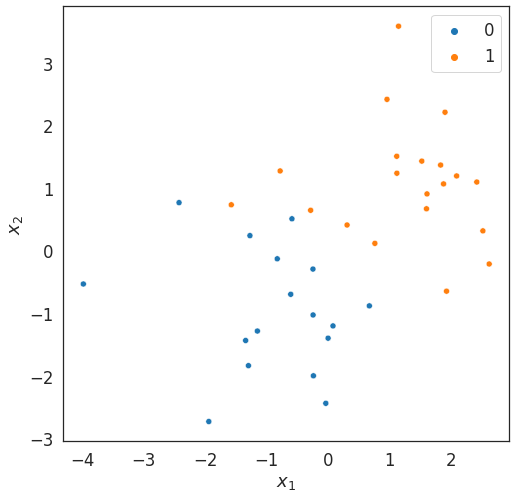

In [ ]:
sns.set_style('white')
f=plt.figure(figsize=(8,8))
sns.set_context('notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

sns.scatterplot(data=x_train,x=x_train[:,-2],y=x_train[:,-1],hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [ ]:
lsc=LeastSquareClassification()

Weight vector [[ 0.52374576  0.47625424]
 [-0.15310116  0.15310116]
 [-0.18810453  0.18810453]]


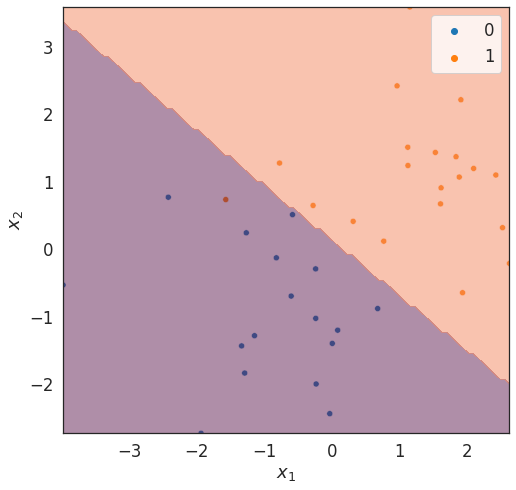

In [ ]:
lsc.fit(x_train,y_train_trans,reg_rate=0)
print("Weight vector",lsc.w)
visualize_model(x_train,y_train,lsc)

In [ ]:

def plot_learning_curve(err_all):
  err=[err[1][1] for err in err_all]
  plt.plot(np.arange(len(err)),err,'r-')
  plt.xlabel('Iter #')
  plt.ylabel('$\mathbf{J(w)}$')

Let's train model with SGD and examine the learning curve

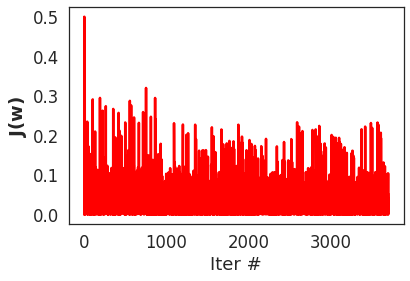

In [ ]:
lsc.sgd(x_train,y_train_trans,num_epochs=100,reg_rate=0)
plot_learning_curve(lsc.err_all)

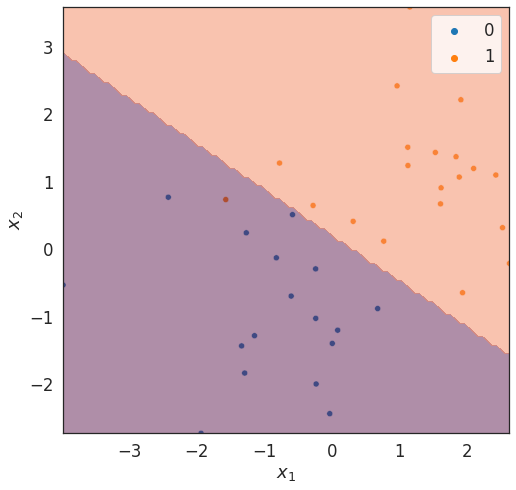

In [ ]:
visualize_model(x_train,y_train,lsc)

In [ ]:
lsc=LeastSquareClassification()
lsc.gd(x_train,y_train_trans,num_epochs=100,reg_rate=0,lr=1e-3)

array([[ 0.50925183,  0.46422172],
       [-0.15072727,  0.15586728],
       [-0.18809366,  0.18710416]])

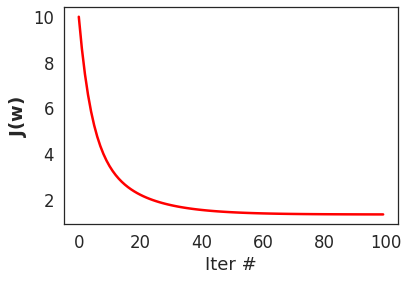

In [ ]:
plot_learning_curve(lsc.err_all)

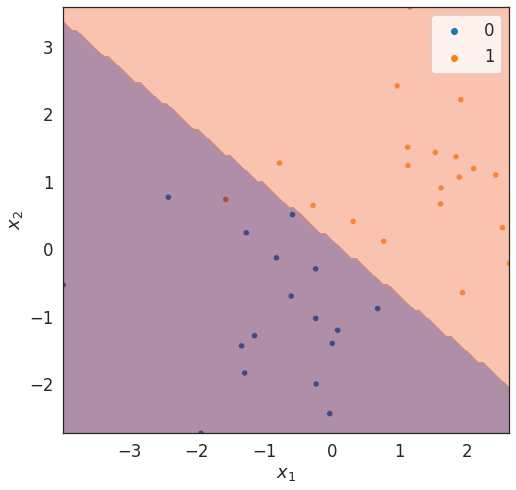

In [ ]:
visualize_model(x_train,y_train,lsc)

###Evaluation metrics

In [ ]:
print(x_test.shape)
y_test_hat=lsc.predict(x_test)

(13, 3)


Get counts of true positive and negatives,false positives and negatives

In [ ]:
tp=np.where((y_test==1)& (y_test_hat==1),1,0).sum()
tn=np.where((y_test==0)& (y_test_hat==0),1,0).sum()
fp=np.where((y_test==0)& (y_test_hat==1),1,0).sum()
fn=np.where((y_test==1)& (y_test_hat==0),1,0).sum()

In [ ]:
from numpy import NaN
def precision(tp,fp):
  if(tp+fp)==0:return NaN
  return tp/(tp+fp)

In [ ]:
def recall(tp,fn):
  if(tp+fn)==0:return NaN
  return tp/(tp+fn)

In [ ]:
def accuracy(tp,fp,tn,fn):
  return (tp+tn)/(tp+tn+fp+fn)

In [ ]:
def fl_score(pr,r): #harmonic mean of pr and r
  return 2*((pr*r)/(pr+r))

In [ ]:
pr=precision(tp,fp)
r=recall(tp,fn)

print("Precision:",pr)
print("Recall:",r)
print("Accuracy:",accuracy(tp,fp,tn,fn))
print("Fl score:",fl_score(pr,r))

Precision: 1.0
Recall: 1.0
Accuracy: 1.0
Fl score: 1.0


##Linearly separable binary classification with outliers

In [ ]:
x_train,x_test,y_train,y_test,y_train_trans,y_test_trans=preprocess(add_outliers=True)

In [ ]:
print("\nShape of training feature matrix:",x_train.shape)
print("Shape of label vector:",y_train.shape)

print("\nShape of test feature matrix:",x_test.shape)
print("Shape of test label vector:",y_test.shape)


Shape of training feature matrix: (41, 3)
Shape of label vector: (41,)

Shape of test feature matrix: (14, 3)
Shape of test label vector: (14,)


##Visualizing

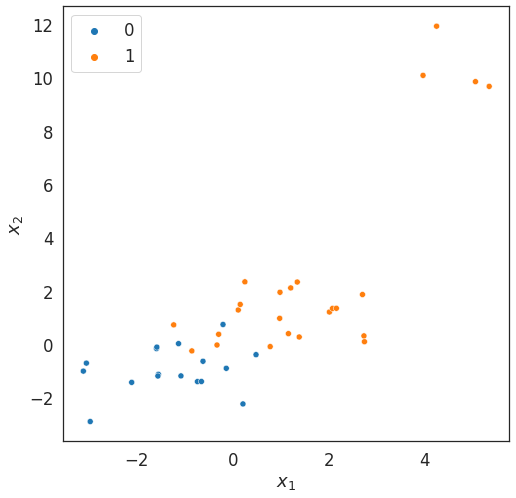

In [ ]:
sns.set_style('white')
f=plt.figure(figsize=(8,8))
sns.set_context('notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

sns.scatterplot(data=x_train,x=x_train[:,-2],y=x_train[:,-1],hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

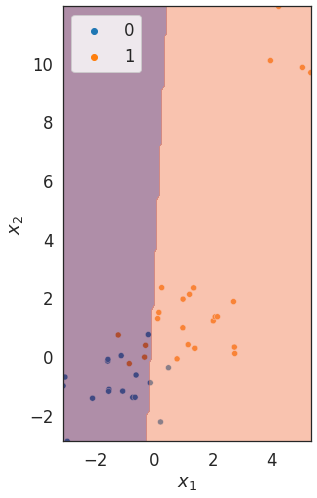

In [ ]:
lsc_outlier=LeastSquareClassification()
lsc_outlier.fit(x_train,y_train_trans,reg_rate=0)
# print("Weight vector",lsc.w)
visualize_model(x_train,y_train,lsc_outlier)

##Demo#3:Multiclass set up

In this set up we demonstrate multi-class set up with three classes

In [ ]:
x_train,x_test,y_train,y_test,y_train_trans,y_test_trans=preprocess(add_class=True)

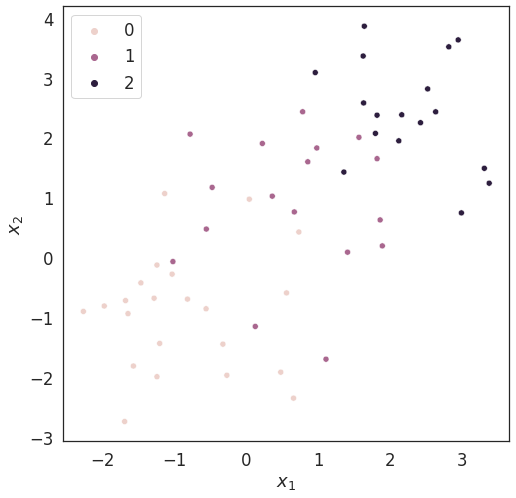

In [ ]:
sns.set_style('white')
f=plt.figure(figsize=(8,8))
sns.set_context('notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

sns.scatterplot(data=x_train,x=x_train[:,-2],y=x_train[:,-1],hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [ ]:
np.unique(y_train)

array([0, 1, 2])

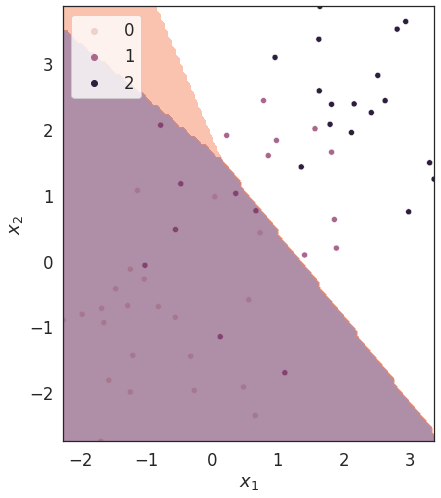

In [ ]:
lsc_multi_class=LeastSquareClassification()
lsc_multi_class.fit(x_train,y_train_trans,reg_rate=0)
# print("Weight vector",lsc.w)
visualize_model(x_train,y_train,lsc_multi_class)

In [ ]:
lsc_multi_class.w

array([[ 0.5484719 ,  0.28935151,  0.16217659],
       [-0.1389778 , -0.00953424,  0.14851204],
       [-0.12683606,  0.03019347,  0.09664259]])

Instead of finding all values of precision and all from scratch let's import `classification_report` api from sklearn

In [ ]:
from sklearn.metrics import classification_report
y_test_pred=lsc_multi_class.predict(x_test)
print(classification_report(y_test,y_test_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      0.12      0.22         8
           2       0.67      1.00      0.80         8

    accuracy                           0.63        19
   macro avg       0.72      0.71      0.56        19
weighted avg       0.78      0.63      0.54        19



##Polynomial least square classification

In [ ]:
from sklearn.datasets import make_circles
x,y=make_circles()


In [ ]:
x_poly=polynomial_transform(x,degree=2)
x_train,x_test,y_train,y_test=train_test_split(x_poly,y)

In [ ]:
print("Shape of feature matrix before transformation",x.shape)
print("Shape of feature matrix after polynomial transformation of degree 2:",x_poly.shape)

Shape of feature matrix before transformation (100, 2)
Shape of feature matrix after polynomial transformation of degree 2: (100, 6)


In [ ]:
x[:5]

array([[-2.47213595e-01,  7.60845213e-01],
       [ 9.29776486e-01, -3.68124553e-01],
       [-6.27905195e-02, -9.98026728e-01],
       [ 7.74866529e-01, -1.98951910e-01],
       [-1.00000000e+00, -3.21624530e-16]])

In [ ]:
x_poly[:5]

array([[ 1.00000000e+00, -2.47213595e-01,  7.60845213e-01,
         6.11145618e-02, -1.88091281e-01,  5.78885438e-01],
       [ 1.00000000e+00,  9.29776486e-01, -3.68124553e-01,
         8.64484314e-01, -3.42273553e-01,  1.35515686e-01],
       [ 1.00000000e+00, -6.27905195e-02, -9.98026728e-01,
         3.94264934e-03,  6.26666168e-02,  9.96057351e-01],
       [ 1.00000000e+00,  7.74866529e-01, -1.98951910e-01,
         6.00418138e-01, -1.54161176e-01,  3.95818624e-02],
       [ 1.00000000e+00, -1.00000000e+00, -3.21624530e-16,
         1.00000000e+00,  3.21624530e-16,  1.03442338e-31]])

In [ ]:
y_train_trans=LabelTransformer().encode(y_train)
y_test_trans=LabelTransformer().encode(y_test)

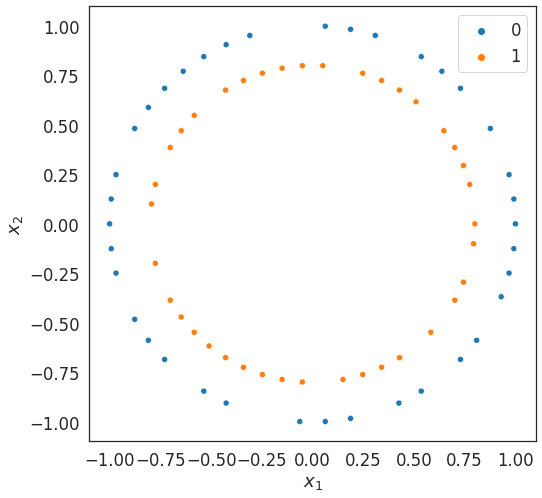

In [ ]:
sns.set_style('white')
f=plt.figure(figsize=(8,8))
sns.set_context('notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

sns.scatterplot(data=x_train,x=x_train[:,1],y=x_train[:,2],hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

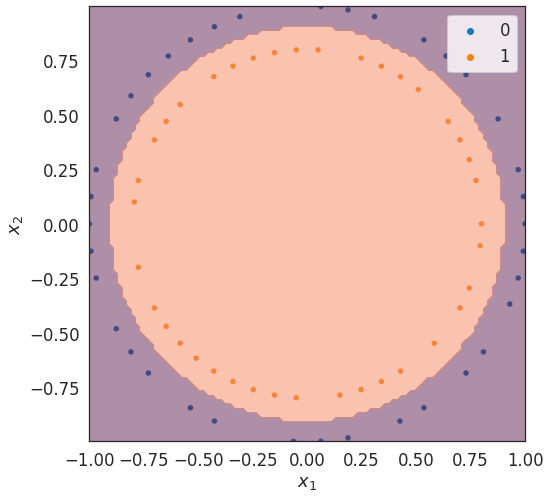

In [ ]:
lsc_poly=LeastSquareClassification()
lsc_poly.fit(x_train,y_train_trans,reg_rate=0)
# print("Weight vector",lsc.w)
visualize_model(x_train,y_train,lsc_poly,degree=2)

In [ ]:
from sklearn.metrics import classification_report
y_test_pred=lsc_poly.predict(x_test)
print(classification_report(y_test,y_test_pred,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



##Perceptron

##Summary of perceptron compponents:

##Training Data
* Feature matrix:$\mathbf{X}_{n.(m+1)}$ includes a dummy feature $x_0$ that is set to 1

* Label vector $y_{n.1}$

Note that perceptron can solve only binary classification problems

##Model

&emsp;&emsp;&emsp;&emsp; $h_w:y=sign(w^T\phi(x))$ <br>
&emsp;&emsp;&emsp;&emsp;      $h_w:y=sign(z)$

where 
* $w$ is a weight vector in $R^{m+1}$

* &emsp;&emsp;&emsp;&emsp;$sign(z)$={$+1,if z>=0$}
* &emsp;&emsp;&emsp;&emsp;$sign(z)$={$-1,otherwise(i.e.z<0)$}

##Loss function

&emsp;&emsp;&emsp;&emsp;$J(w)=\sum_{i=1}^n e^{i}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$=\sum_{i=1}^n max(-h_w(x^i)y^i,0)$


##Optimization procedure(Perceptron update rule)

1. Initialize $w^0=0$
2. For each training example($x^i,y^i$):
  * $ycap^i=sign(w^Tx^i)$ [Calculate the output value]
  * $w^{(i+1)}:=w^{i}+\alpha(y^i-ycap^i)\phi(x^i)$ [Update the weights]


##Evaluation metrics
* Confusion matrix
* Precision/Recall/Fl



##Implementation

In [ ]:
#@title [import libraries]

from IPython.display import display,Math,Latex

np.random.seed(1234)


In [ ]:
def create_toy_data(factor=3):
    x0 = np.random.normal(size=50).reshape(-1, 2) - factor
    x1 = np.random.normal(size=50).reshape(-1, 2) + factor
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25)-1, np.ones(25)]).astype(np.int64)

In [ ]:
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(X_train, labels, lsc, degree=1):
    f = plt.figure(figsize=(8,8))

    x1_min = np.min(x_train[:,1])
    x1_max = np.max(x_train[:,1])
    x2_min = np.min(x_train[:,2])
    x2_max = np.max(x_train[:,2])
    
    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100)) 
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc.predict(x_test_poly)
    
    sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))
    plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
class Perceptron:
  '''
  Implements perceptron class

  It uses the following class variable:
  w:stores the final weight vector
  w_all:stores all weight vector in training iterations
  errors_all:stores all errors in training iterations. 
  '''

  def __init__(self):
    return

  def predict(self,X):
    '''Predicts labels for input feature matrix X.'''
    z=X@self.w
    return np.where(z>=0,1,-1)
  
  def loss(self,X,y):
    '''
    Calculate loss

    Calculate loss due to current weight vector w on feature matrix X and label vector y.

    Args:
      X:Feature matrix
      y:Label vector

    Returns:
      None
    '''
    return np.sum(np.maximum(-1*self.predict(X)*y,np.zeros(y.shape[0])))


  def train(self,X,y,epochs=10,lr=0.001):
    '''
    Implements perceptron update rule.

    Args:
      X:feature matrix
      y:label vector
      epochs:Number of epochs
      lr:learning rate
    Returns:
      None
    '''
    self.w=np.zeros(X.shape[1])
    self.errors_all=[]
    self.w_all=[]

    for _ in range(epochs):
      errors=0
      for xi,target in zip(X,y):
        self.w+=lr*(target-self.predict(xi))*xi
        errors+=(max(-1*self.predict(xi)*target,0))
      
      self.errors_all.append(errors)
      self.w_all.append(self.w)
      print("w:",perceptron_obj.w)
      print("J(w):",perceptron_obj.errors_all[-1])

      #Note:Commented for loss visualization.Uncomment in actual implementation
      # if self.loss(X,y)==0:
      # break


In [ ]:
from sklearn.model_selection import train_test_split
x,y=create_toy_data()
x_poly=polynomial_transform(x,degree=1)
x_train,x_test,y_train,y_test=train_test_split(x_poly,y)

w: [-2.          7.68129869  5.97862843]
J(w): 0
w: [-2.          7.68129869  5.97862843]
J(w): 0
w: [-2.          7.68129869  5.97862843]
J(w): 0
w: [-2.          7.68129869  5.97862843]
J(w): 0
w: [-2.          7.68129869  5.97862843]
J(w): 0
w: [-2.          7.68129869  5.97862843]
J(w): 0
w: [-2.          7.68129869  5.97862843]
J(w): 0
w: [-2.          7.68129869  5.97862843]
J(w): 0
w: [-2.          7.68129869  5.97862843]
J(w): 0
w: [-2.          7.68129869  5.97862843]
J(w): 0


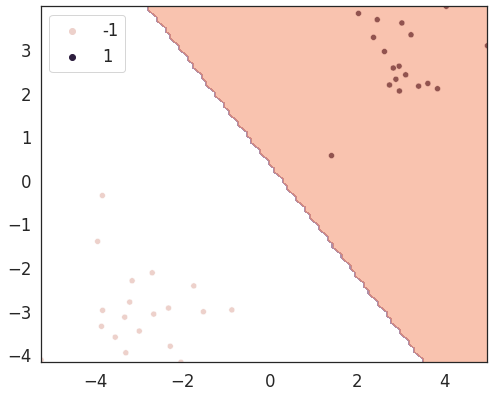

In [ ]:
perceptron_obj=Perceptron()
perceptron_obj.train(x_train,y_train,lr=1)
visualize_model(x_train,y_train,perceptron_obj,degree=1)

In [ ]:
perceptron_obj.errors_all

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Text(0.5, 1.0, 'Learning curve')

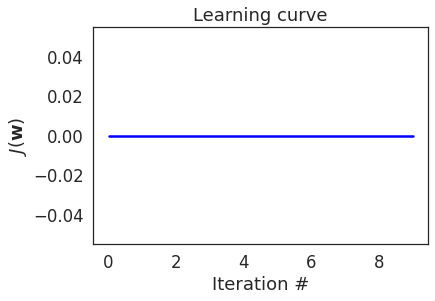

In [ ]:
plt.plot(np.arange(len(perceptron_obj.errors_all)),perceptron_obj.errors_all,'b-')
plt.xlabel('Iteration #')
plt.ylabel('$J(\mathbf{w})$')
plt.title('Learning curve')

##Linearly non-sepearable case

In [ ]:
x,y=create_toy_data(factor=0.5)
x_poly=polynomial_transform(x,degree=1)
x_train,x_test,y_train,y_test=train_test_split(x_poly,y)

perceptron_obj=Perceptron()
perceptron_obj.train(x_train,y_train,lr=1)

w: [-2.          2.54485624  2.14362076]
J(w): 2
w: [0.         4.73236168 0.33187163]
J(w): 2
w: [0.         4.10688596 0.45278821]
J(w): 2
w: [0.         3.48141025 0.57370479]
J(w): 3
w: [-2.          2.93482666  1.11477839]
J(w): 4
w: [-2.          2.95512553  1.00135562]
J(w): 5
w: [-2.          2.9754244   0.88793285]
J(w): 5
w: [-2.          2.99572326  0.77451008]
J(w): 5
w: [0.         4.65019535 0.49449155]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2


w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.61540812]
J(w): 2
w: [0.         4.02471963 0.615408

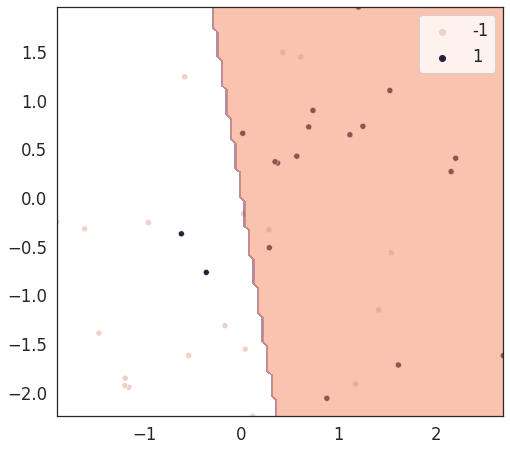

In [ ]:
p = Perceptron()
p.train(x_train, y_train,epochs=100, lr=1)
#In non-linear separable case, the classification doesn't converge, but oscillate.  Print loss to see.
visualize_model(x_train, y_train, p, degree=1)